In [73]:
!pip install langchain==0.3.24 -q
!pip install -q -U google-generativeai langchain-google-genai
!pip install langchain_chroma -q
!pip install langchain_community -q
!pip install langgraph -q
!pip install pypdf -q
!pip install duckduckgo-search -qU

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-community 0.3.24 requires langchain<1.0.0,>=0.3.25, but you have langchain 0.3.24 which is incompatible.


In [104]:
import os
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage, SystemMessage, HumanMessage, ToolMessage
from operator import add as add_messages
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma
from langchain_core.tools import tool
from langchain_community.tools import DuckDuckGoSearchRun

In [105]:
import os
from google.colab import userdata

google_api_key = userdata.get('GEMINI_API_KEY')

In [106]:
llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash-preview-05-20",
    google_api_key=google_api_key,
    temperature=0.9
)

In [107]:
embeddings = GoogleGenerativeAIEmbeddings(
    model="models/embedding-001",
    google_api_key=google_api_key
)

In [108]:
pdf_loader = PyPDFLoader("/content/EE_E19_056_report_Final.pdf")

In [109]:
pages = pdf_loader.load()

In [110]:
pages

[Document(metadata={'producer': 'iLovePDF', 'creator': 'PyPDF', 'creationdate': '', 'moddate': '2025-04-20T05:26:25+00:00', 'source': '/content/EE_E19_056_report_Final.pdf', 'total_pages': 73, 'page': 0, 'page_label': '1'}, page_content='TR400 - INDUSTRIAL TRAINING \n \n \nINDUSTRIAL TRAINING REPORT \n \n \n \n \n \n \n \n \nFACULTY OF ENGINEERING  \nUNIVERSITY OF PERADENIYA  \nSRI LANKA \nT.A VISAL CHATHURANGA \nE/19/056 \nELECTRICAL AND ELECTRONIC \nENGINEERING'),
 Document(metadata={'producer': 'iLovePDF', 'creator': 'PyPDF', 'creationdate': '', 'moddate': '2025-04-20T05:26:25+00:00', 'source': '/content/EE_E19_056_report_Final.pdf', 'total_pages': 73, 'page': 1, 'page_label': '2'}, page_content='INDUSTRIAL TRAINING REPORT I \n \n  TRAINING ORGANIZATION  : PHOENIX INDUSTRIES LTD  \n  PERIOD OF TRAINING          : FROM 31/07/2023 TO 20/10/2023 \n           FIELD OF SPECIALIZATION : ELECTRICAL AND ELECTRONIC     \n                                                              ENGINEERI

In [111]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200
)

In [112]:
pages_split = text_splitter.split_documents(pages)

In [113]:
len(pages_split)

175

In [114]:
vectorstore = Chroma.from_documents(
    documents=pages_split,
    embedding=embeddings,
    persist_directory="./vectorstore",
    collection_name="data"
)

In [117]:
retriever = vectorstore.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 5}
)

In [118]:
@tool
def retriever_tool(query: str) -> str:
    """
    This tool searches and returns the information about my training report.
    """
    docs = retriever.invoke(query)
    if not docs:
        return "I found no relevant information"
    results = []
    for i, doc in enumerate(docs):
        results.append(f"Document {i+1}:\n{doc.page_content}")

    return "\n\n".join(results)

# Initialize DuckDuckGo search tool
search_tool = DuckDuckGoSearchRun()

In [120]:
tools = [retriever_tool, search_tool]

llm_with_tools = llm.bind_tools(tools)

In [121]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [122]:
def should_continue(state: AgentState):
    """Check if the last message contains tool calls."""
    result = state['messages'][-1]
    return hasattr(result, 'tool_calls') and len(result.tool_calls) > 0

In [123]:
system_prompt = """
You are an intelligent AI assistant who answers questions about my training report based on the PDF document loaded into your knowledge base.
Use the retriever tool available to answer questions about the given data. You can make multiple calls if needed.
If you need to look up some information before asking a follow up question, you are allowed to do that!
Please always cite the specific parts of the documents you use in your answers.
"""

In [124]:
tools_dict = {our_tool.name: our_tool for our_tool in tools}

In [126]:
# LLM Agent
def call_llm(state: AgentState) -> AgentState:
    """Function to call the LLM with the current state."""
    messages = list(state['messages'])
    messages = [SystemMessage(content=system_prompt)] + messages
    message = llm_with_tools.invoke(messages)
    print(message)
    return {'messages': [message]}

In [127]:
# Retriever Agent
def take_action(state: AgentState) -> AgentState:
    """Execute tool calls from the LLM's response."""

    tool_calls = state['messages'][-1].tool_calls
    results = []
    for t in tool_calls:
        print(f"Calling Tool: {t['name']} with query: {t['args'].get('query', 'No query provided')}")

        if not t['name'] in tools_dict: # Checks if a valid tool is present
            print(f"\nTool: {t['name']} does not exist.")
            result = "Incorrect Tool Name, Please Retry and Select tool from List of Available tools."

        else:
            result = tools_dict[t['name']].invoke(t['args'].get('query', ''))
            print(f"Result length: {len(str(result))}")


        # Appends the Tool Message
        results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))

    print("Tools Execution Complete. Back to the model!")
    return {'messages': results}

In [128]:
workflow = StateGraph(AgentState)

workflow.add_node("llm", call_llm)
workflow.add_node("retriever_agent", take_action)

workflow.add_edge(START, "llm")
workflow.add_conditional_edges(
    "llm",
    should_continue,
    {True: "retriever_agent", False: END}
)
workflow.add_edge("retriever_agent", "llm")

app = workflow.compile()

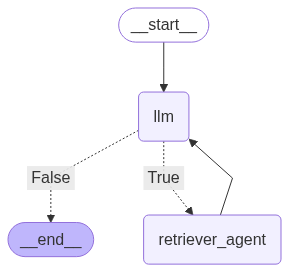

In [129]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [130]:
result = app.invoke({"messages": [HumanMessage(content="what are the all companies i go to the training?")]})

content='' additional_kwargs={'function_call': {'name': 'retriever_tool', 'arguments': '{"query": "companies I go to for training"}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []} id='run--1068dd64-b60e-494c-a9c2-5818cc92fdb6-0' tool_calls=[{'name': 'retriever_tool', 'args': {'query': 'companies I go to for training'}, 'id': '914331fb-30d9-44e2-a044-2bbcecd58917', 'type': 'tool_call'}] usage_metadata={'input_tokens': 208, 'output_tokens': 21, 'total_tokens': 283, 'input_token_details': {'cache_read': 0}}
Calling Tool: retriever_tool with query: companies I go to for training
Result length: 3554
Tools Execution Complete. Back to the model!
content='You went to Phoenix Industries Ltd. for training. (Documents 1, 2, and 3)' additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []} id='run--f61adbaf-d3f0-4f42-b797-59d1

In [132]:
result = app.invoke({"messages": [HumanMessage(content="can you deep explanation of the reflow oven project?")]})

content='' additional_kwargs={'function_call': {'name': 'retriever_tool', 'arguments': '{"query": "reflow oven project"}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []} id='run--6f1a0b15-3976-425f-a262-8d408b197ea1-0' tool_calls=[{'name': 'retriever_tool', 'args': {'query': 'reflow oven project'}, 'id': 'f8c11556-0e1c-4072-b44f-81cbf11b5f2b', 'type': 'tool_call'}] usage_metadata={'input_tokens': 208, 'output_tokens': 19, 'total_tokens': 289, 'input_token_details': {'cache_read': 0}}
Calling Tool: retriever_tool with query: reflow oven project
Result length: 4926
Tools Execution Complete. Back to the model!
content="The Reflow Oven Profile Predictor is a software application designed to optimize the manufacturing process of Printed Circuit Boards (PCBs). Its primary objective is to improve the efficiency and accuracy of setting up and operating reflow ovens, which are crucial for heating PCBs during produ